# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [129]:
17

17

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [130]:
import numpy as np
import pandas as pd
import missingno as msno
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from yellowbrick.classifier import ClassificationReport

warnings.filterwarnings('ignore')

In [131]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [132]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [133]:
#Change column name: 'y' to 'response'
df.rename(index=str, columns={'y': 'response'}, inplace = True)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



<AxesSubplot:>

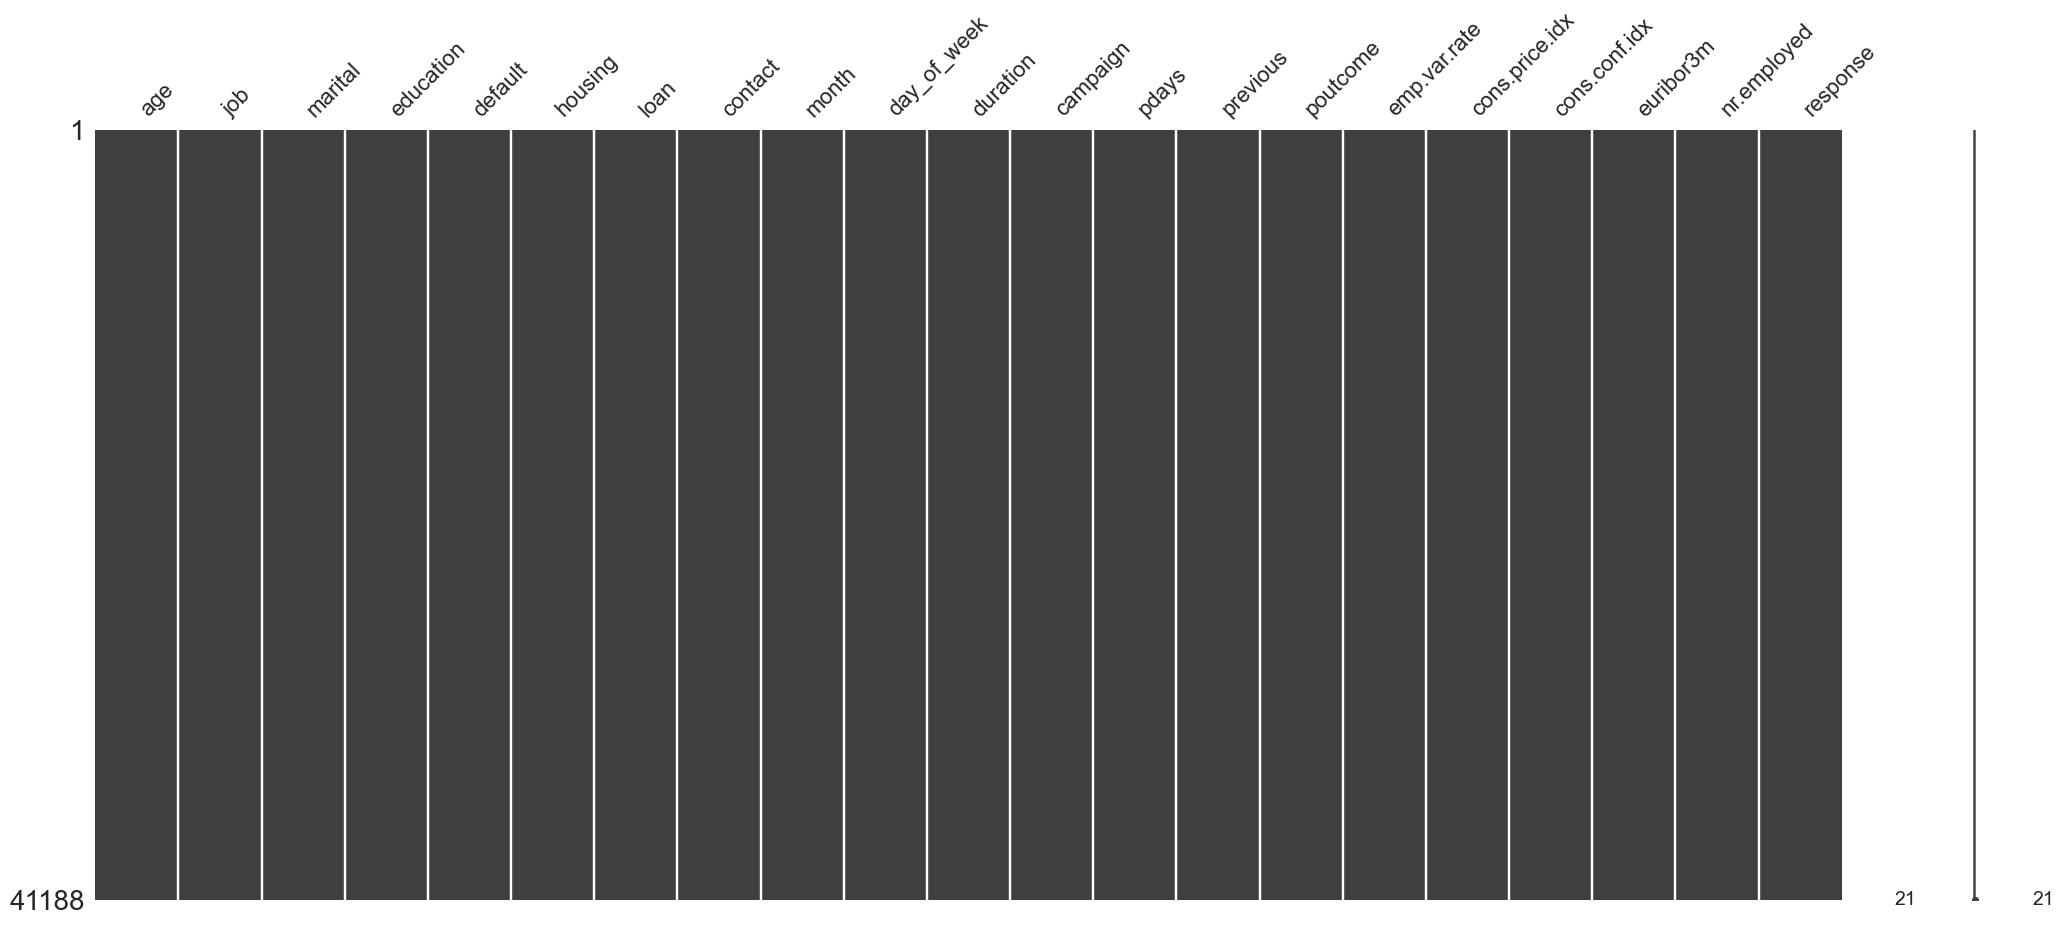

In [134]:
# using Missing Data python package on the df to visualize missing values
msno.matrix(df)

<AxesSubplot:>

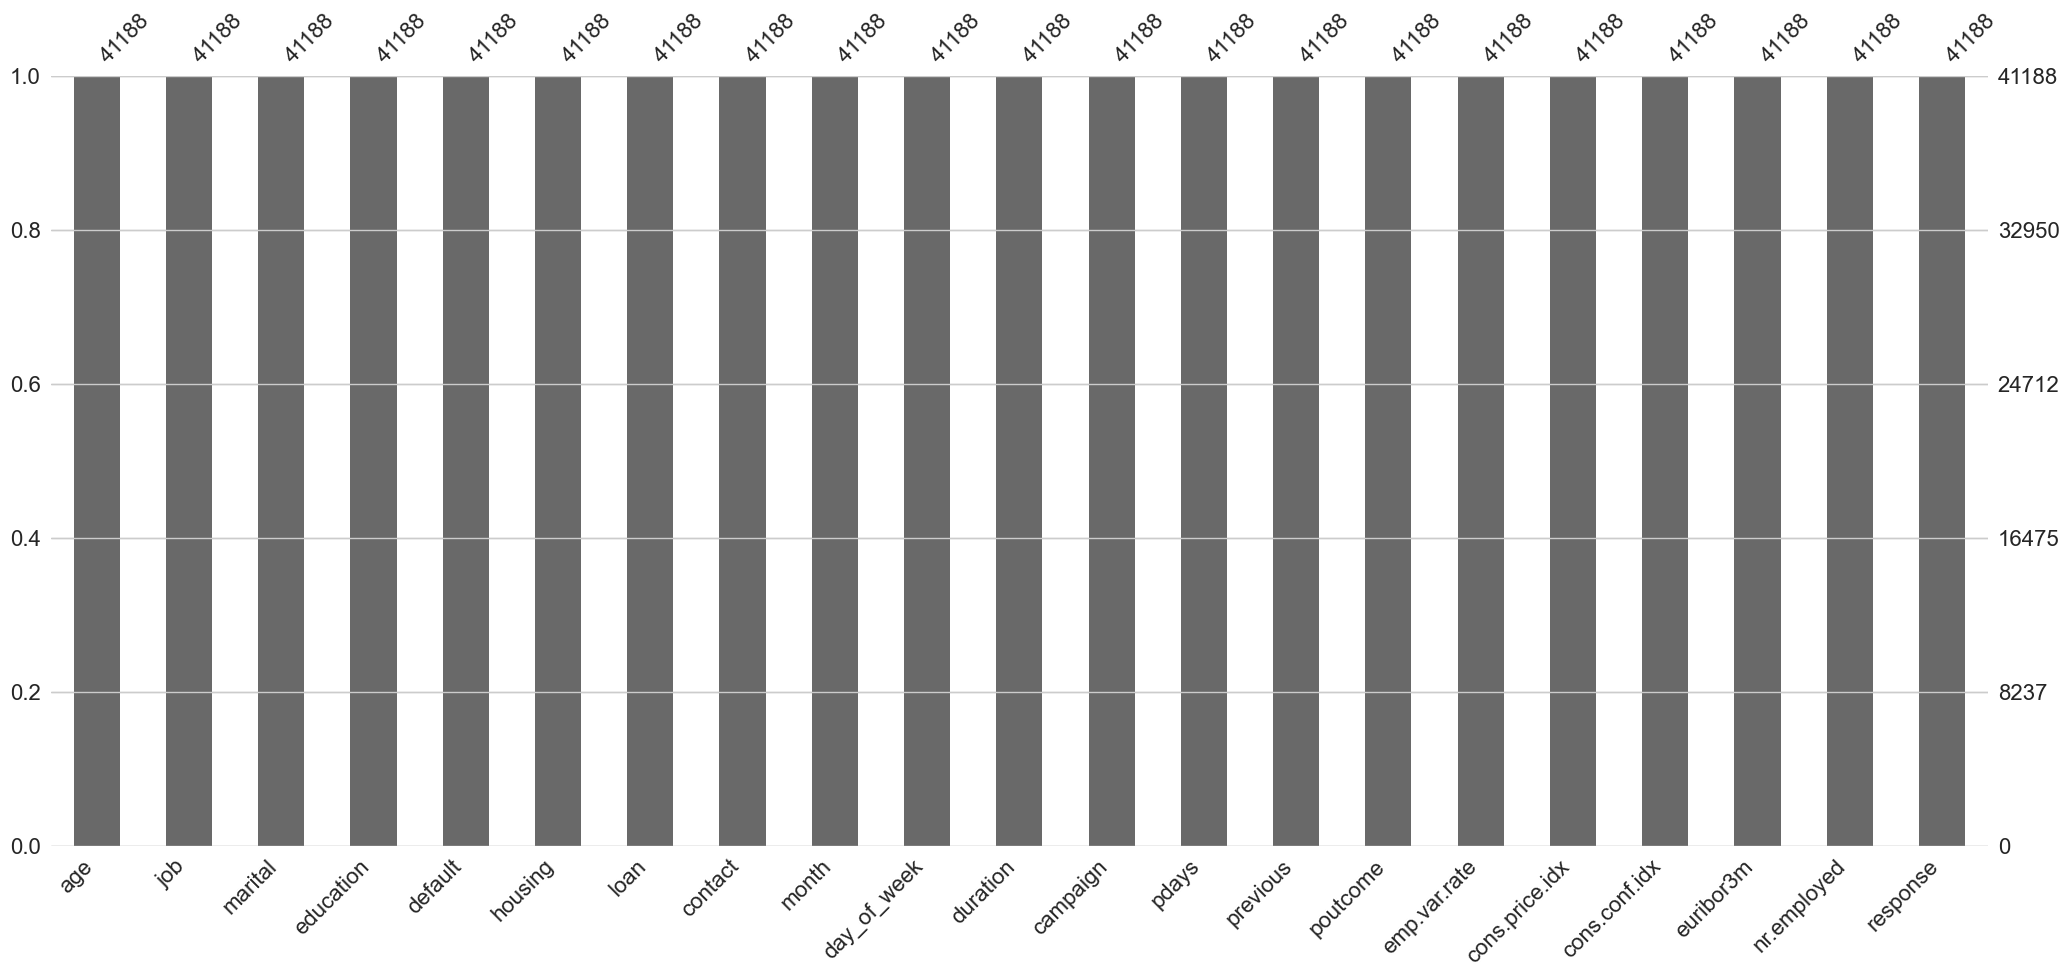

In [135]:
msno.bar(df)

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

##### Objective Goes Here

<i>A well-trained ML model's objective is to predict accurately if the customer accepts an attractive long-term deposit application during a direct marketing campaign call.</i> 

In [136]:
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  Int64  
 1   job             41188 non-null  string 
 2   marital         41188 non-null  string 
 3   education       41188 non-null  string 
 4   default         41188 non-null  string 
 5   housing         41188 non-null  string 
 6   loan            41188 non-null  string 
 7   contact         41188 non-null  string 
 8   month           41188 non-null  string 
 9   day_of_week     41188 non-null  string 
 10  duration        41188 non-null  Int64  
 11  campaign        41188 non-null  Int64  
 12  pdays           41188 non-null  Int64  
 13  previous        41188 non-null  Int64  
 14  poutcome        41188 non-null  string 
 15  emp.var.rate    41188 non-null  Float64
 16  cons.price.idx  41188 non-null  Float64
 17  cons.conf.idx   41188 non-null  Floa

In [137]:
# Checking for class imbalance
df['response'].value_counts()

no     36548
yes     4640
Name: response, dtype: Int64

##### Visualizations ( using seaborne )

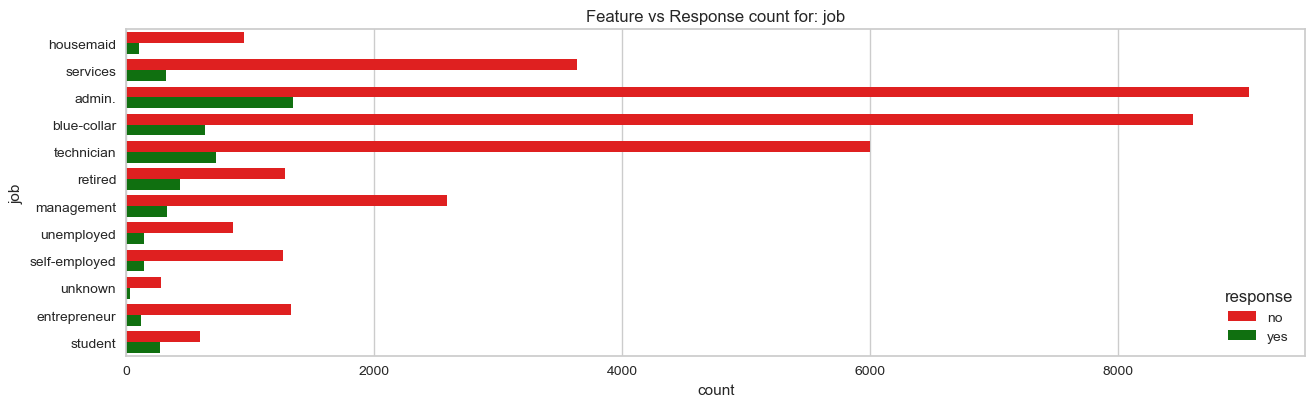

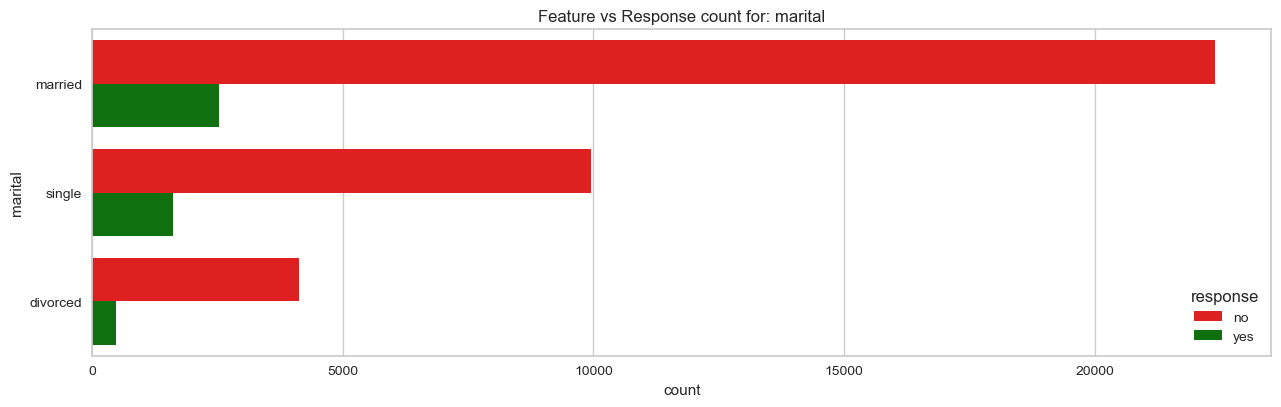

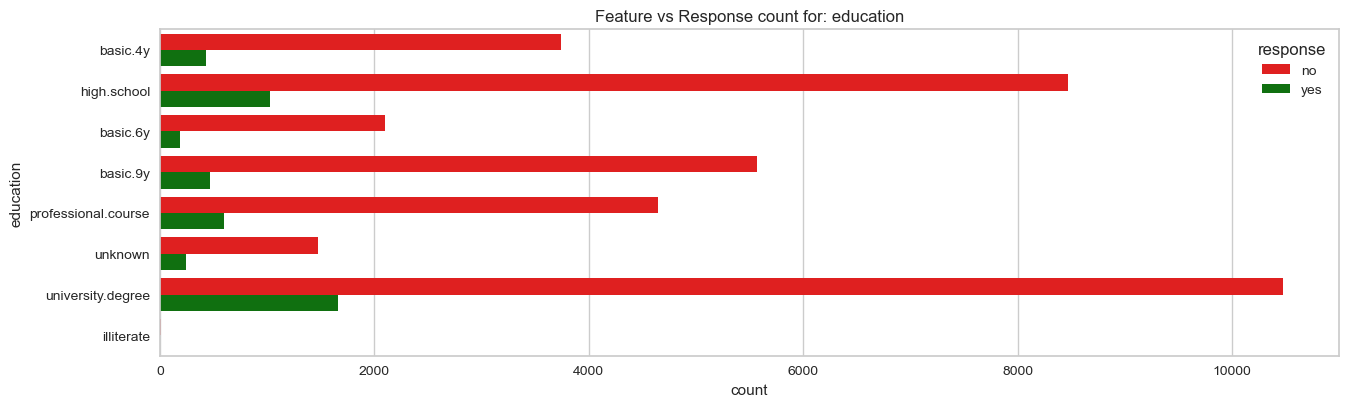

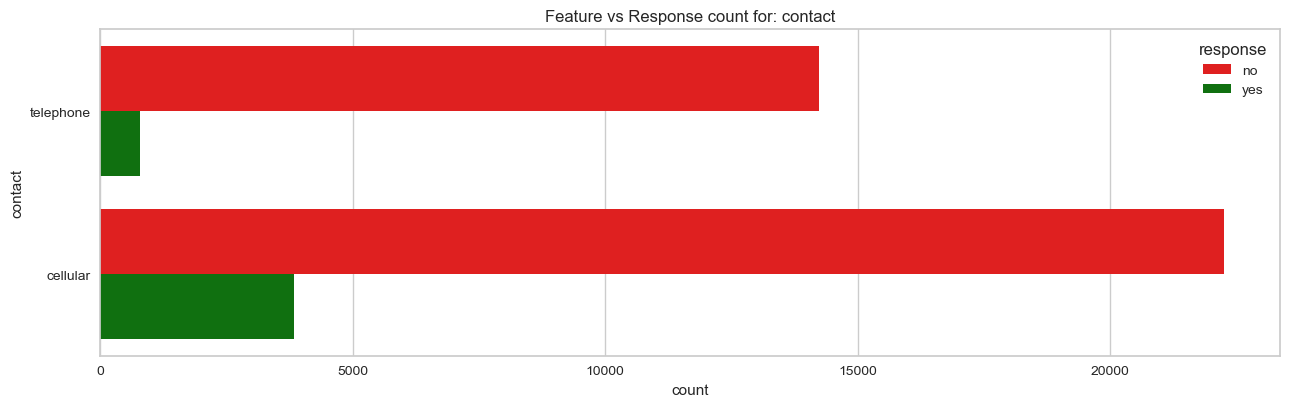

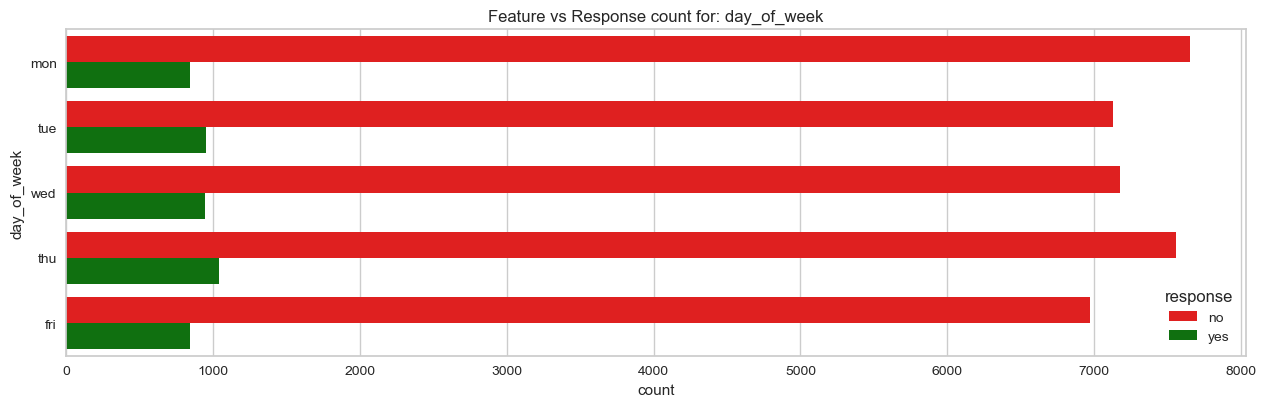

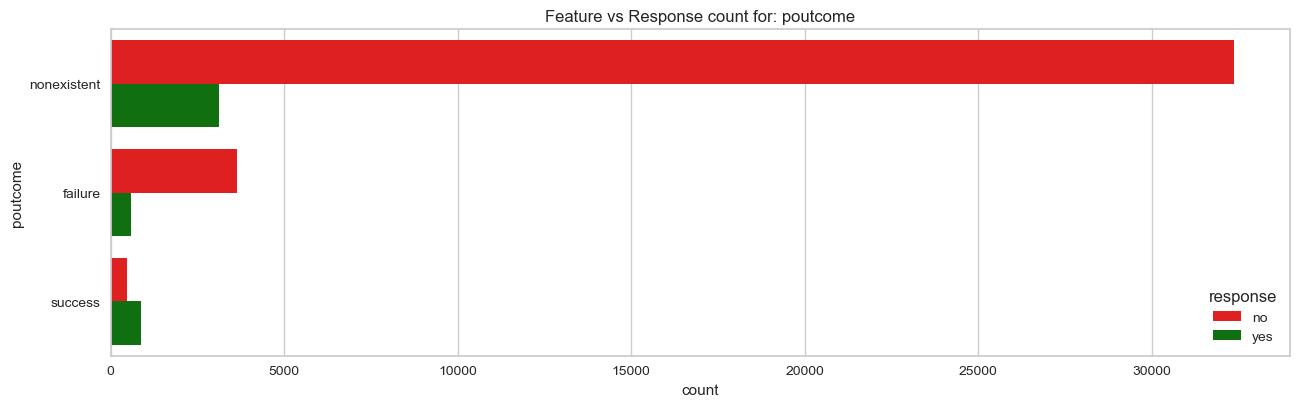

In [213]:
cat_cols = ['job','marital','education','contact', 'day_of_week','poutcome']
palette_colors = {"yes": "green", "no": "red"}

for i, var in enumerate(cat_cols):
    plt.figure(figsize=(70,50))
    plt.subplot(10,4,i+1)
    plt.title('Feature vs Response count for: '+var)
    sns.countplot(y=var, data=df, hue=df.response, palette=palette_colors)
    plt.show()

##### Distribution plots to understand campaign data

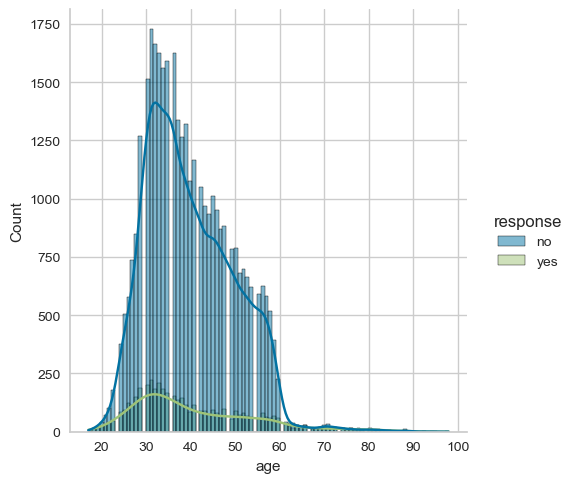

In [139]:
# Looking at distribution of age & response
sns.displot(df, x=df['age'], color='green', kde=True, hue='response')

##### Conclusion: 
- Most of the customers who have subscribed to term deposits are in the 30 to 35 age group - Target Group #1 for a higher success

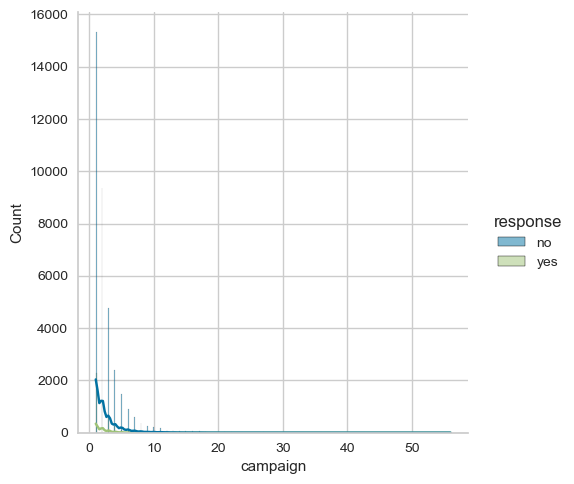

In [140]:
sns.displot(df, x=df['campaign'], color='green',kde=True, hue='response')

#### Is there a trend between age, campaign?

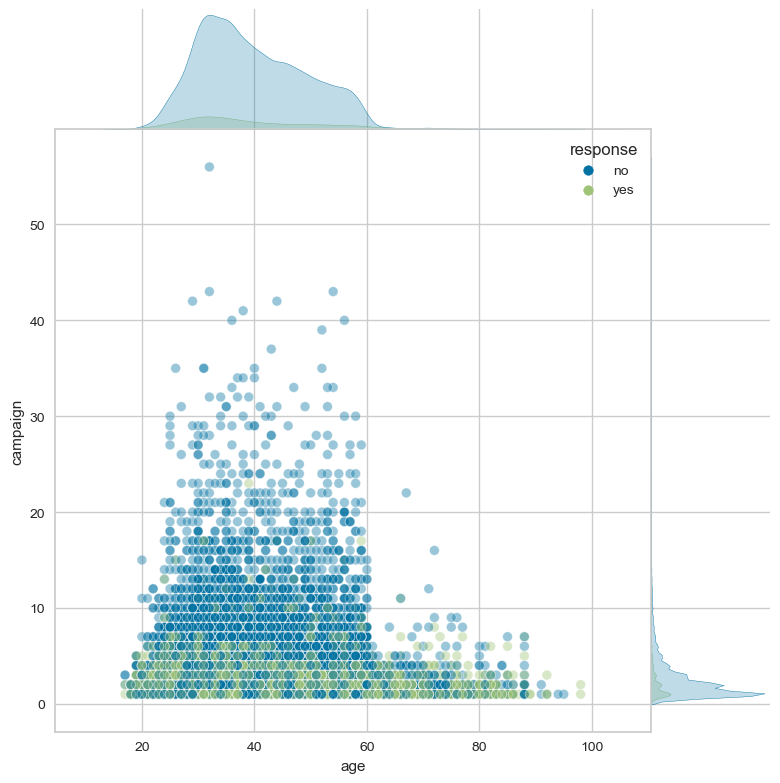

In [141]:
sns.jointplot(x='age', y='campaign', data=df, alpha=0.4, height=8, ratio=5, space=0, hue='response')

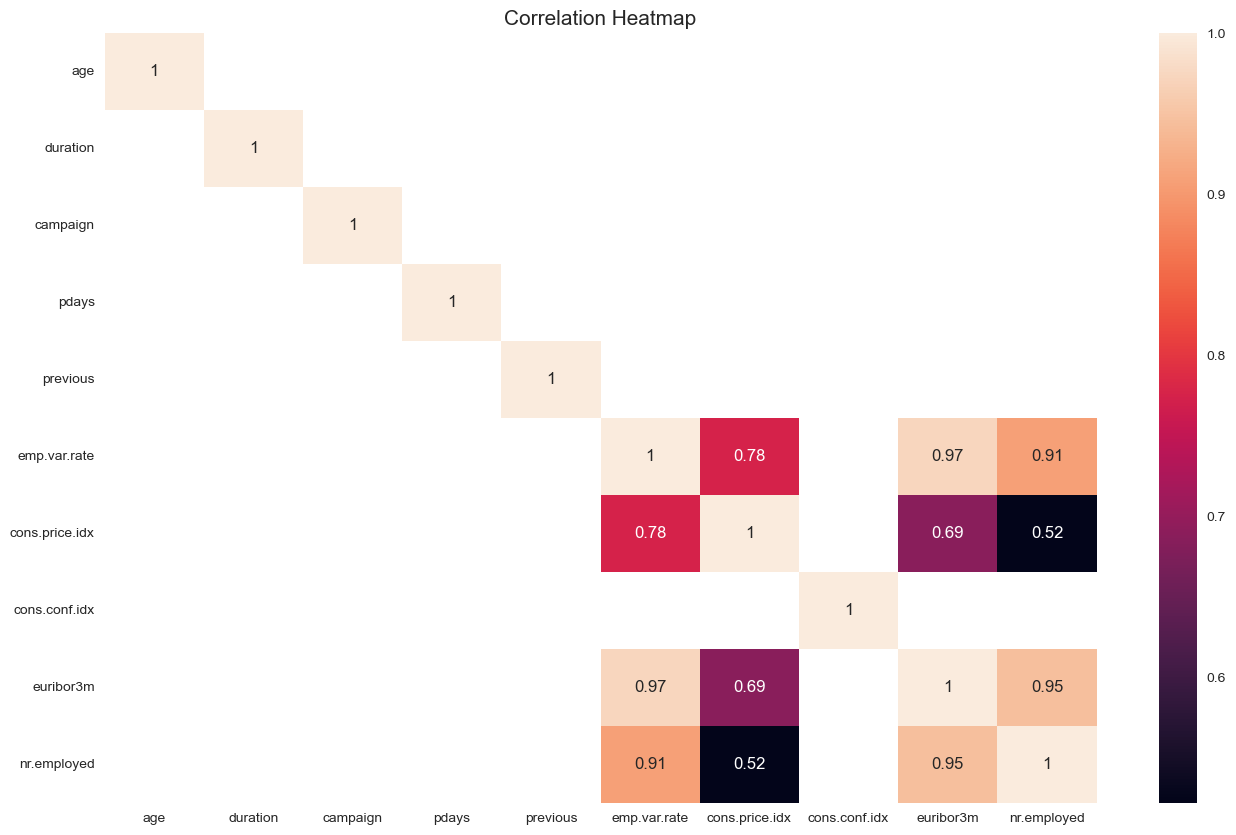

In [211]:
# Calculating correlation
corr_matrix = df.corr()

# plotting the heatmap of only highly correlated varibles with threshold value 0.5
plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix[corr_matrix > 0.5], annot=True)
plt.title("Correlation Heatmap",  fontsize = 15)
plt.show()

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [143]:
# Are there any outliers?
def find_boundaries(df, variable, distance):
  IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

  lower_boundary = df[variable].quantile(0.25) - (IQR*distance)
  upper_boundary = df[variable].quantile(0.75) + (IQR*distance)

  return lower_boundary, upper_boundary

In [144]:
lo, up = find_boundaries(df, 'age', 1.5)
outliers = np.where(df['age'] > up, True, 
                    np.where(df['age'] < lo, True, False))

df.loc[~outliers]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,37,admin.,married,university.degree,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41182,29,unemployed,single,basic.4y,no,yes,no,cellular,nov,fri,...,1,9,1,success,-1.1,94.767,-50.8,1.028,4963.6,no
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no


In [145]:
# drop "unknown" values from job, marital & education
print("# Missing value 'job' variable: {0}".format(len(df.loc[df['job'] == "unknown"])))
print("# Missing value 'marital' variable: {0}".format(len(df.loc[df['marital'] == "unknown"])))
print("# Missing value 'education' variable: {0}".format(len(df.loc[df['education'] == "unknown"])))
print("# Missing value 'default' variable: {0}".format(len(df.loc[df['default'] == "unknown"])))
print("# Missing value 'housing' variable: {0}".format(len(df.loc[df['housing'] == "unknown"])))
print("# Missing value 'loan' variable: {0}".format(len(df.loc[df['loan'] == "unknown"])))
print("# Missing value 'contact' variable: {0}".format(len(df.loc[df['contact'] == "unknown"])))
print("# Missing value 'month' variable: {0}".format(len(df.loc[df['month'] == "unknown"])))
print("# Missing value 'day_of_week' variable: {0}".format(len(df.loc[df['day_of_week'] == "unknown"])))
print("# Missing value 'poutcome' variable: {0}".format(len(df.loc[df['poutcome'] == "unknown"])))

# Missing value 'job' variable: 330
# Missing value 'marital' variable: 80
# Missing value 'education' variable: 1731
# Missing value 'default' variable: 8597
# Missing value 'housing' variable: 990
# Missing value 'loan' variable: 990
# Missing value 'contact' variable: 0
# Missing value 'month' variable: 0
# Missing value 'day_of_week' variable: 0
# Missing value 'poutcome' variable: 0


In [148]:
# removing "unknown" values from marital status as it provides little value
df.drop(df[df['marital'] == "unknown"].index, inplace=True)

In [149]:
# Using SKLEARN LabelEncoder to encode columns : marital, education, loan, contact, month, day_of_week
df_encoded = df.apply(LabelEncoder().fit_transform)
df_encoded

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,39,3,1,0,0,0,0,1,6,1,...,0,26,0,1,8,18,16,287,8,0
1,40,7,1,3,1,0,0,1,6,1,...,0,26,0,1,8,18,16,287,8,0
2,20,7,1,3,0,2,0,1,6,1,...,0,26,0,1,8,18,16,287,8,0
3,23,0,1,1,0,0,0,1,6,1,...,0,26,0,1,8,18,16,287,8,0
4,39,7,1,3,0,0,2,1,6,1,...,0,26,0,1,8,18,16,287,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,56,5,1,5,0,2,0,0,7,0,...,0,26,0,1,5,25,0,171,0,1
41184,29,1,1,5,0,0,0,0,7,0,...,0,26,0,1,5,25,0,171,0,0
41185,39,5,1,6,0,2,0,0,7,0,...,1,26,0,1,5,25,0,171,0,0
41186,27,9,1,5,0,0,0,0,7,0,...,0,26,0,1,5,25,0,171,0,1


In [150]:
data, target = df_encoded.drop(columns = 'response'), df_encoded.response

In [151]:
# SMOTE to handle class imbalance
os = SMOTE()
X, y = os.fit_resample(data, target)
y.value_counts()

0    36480
1    36480
Name: response, dtype: int64

In [152]:
# Pandas-Profiling
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

#### Statistical Analysis of the dataset

In [153]:
df_encoded.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
count,41108.000000,41108.000000,41108.000000,41108.000000,41108.000000,41108.000000,41108.000000,41108.000000,41108.000000,41108.000000,...,41108.000000,41108.000000,41108.000000,41108.00000,41108.000000,41108.00000,41108.000000,41108.000000,41108.000000,41108.000000
mean,23.023134,3.722025,1.169213,3.746132,0.209010,1.072078,0.327455,0.365306,4.230077,2.004719,...,1.565632,25.265423,0.172764,0.93016,6.589593,14.19838,10.336382,255.651552,7.846380,0.112581
std,10.418399,3.593209,0.604130,2.136149,0.406786,0.985276,0.723627,0.481522,2.320323,1.397769,...,2.756266,3.831576,0.494773,0.36266,2.797576,5.55909,5.978462,68.662101,2.455089,0.316084
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,...,0.000000,26.000000,0.000000,1.00000,3.000000,10.00000,6.000000,214.000000,6.000000,0.000000
50%,21.000000,2.000000,1.000000,3.000000,0.000000,2.000000,0.000000,0.000000,4.000000,2.000000,...,1.000000,26.000000,0.000000,1.00000,8.000000,14.00000,8.000000,287.000000,8.000000,0.000000
75%,30.000000,7.000000,2.000000,6.000000,0.000000,2.000000,0.000000,1.000000,6.000000,3.000000,...,2.000000,26.000000,0.000000,1.00000,9.000000,18.00000,16.000000,305.000000,10.000000,0.000000
max,77.000000,11.000000,2.000000,7.000000,2.000000,2.000000,2.000000,1.000000,9.000000,4.000000,...,41.000000,26.000000,7.000000,2.00000,9.000000,25.00000,25.000000,315.000000,10.000000,1.000000


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

### Problem 7: A Baseline Model

In [156]:
# A baseline model is one in which we can always guess the most frequently occurring class.
baseline = df['response'].value_counts(normalize = True)[0]
print(f"Baseline performance (most frequently occuring class): {baseline}")

Baseline performance (most frequently occuring class): 0.8874185073465019


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [203]:
# Calculations performed after balancing the data
model = LogisticRegression()

### Problem 9: Score the Model

What is the accuracy of your model?

In [158]:
def score_model(X, y, model):
    model.fit(X, y)
    expected  = y
    predicted = model.predict(X)

    return accuracy_score(expected, predicted)

In [159]:
print("Training Accuracy Score: ", score_model(X_train, y_train, model))
print("Test Accuracy Score: ", score_model(X_test, y_test, model))

Training Accuracy Score:  0.8639437134502924
Test Accuracy Score:  0.8628837719298246


              precision    recall  f1-score   support

           0       0.94      0.92      0.93      9133
           1       0.92      0.94      0.93      9107

    accuracy                           0.93     18240
   macro avg       0.93      0.93      0.93     18240
weighted avg       0.93      0.93      0.93     18240

---------------------------------------------------------------------------------------


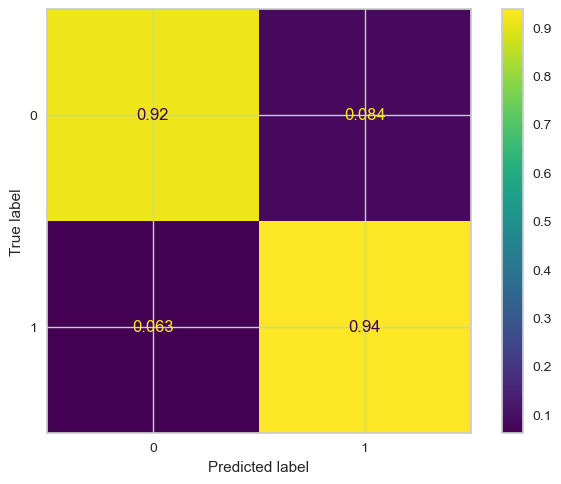

In [202]:
y_pred_baseline = model.predict(X_test)
print(classification_report(y_test, y_pred_baseline))
print('---------------------------------------------------------------------------------------')
plot_confusion_matrix(estimator=model, X=X_test, y_true=y_test, normalize='true')

#### Conclusion: 
 - LogisticRegression is performing well on both the train & test data with almost identical accuracy scores.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

##### Visual Model Evaluation using YellowBrick Package

In [160]:
models = [
    LogisticRegression(), SVC(gamma='auto'), KNeighborsClassifier(), DecisionTreeClassifier()
]

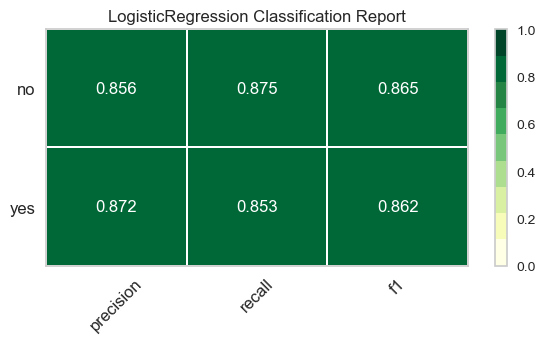

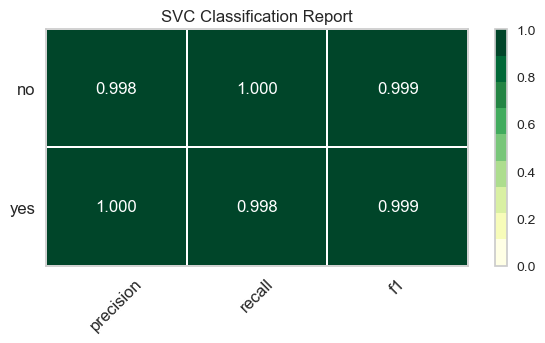

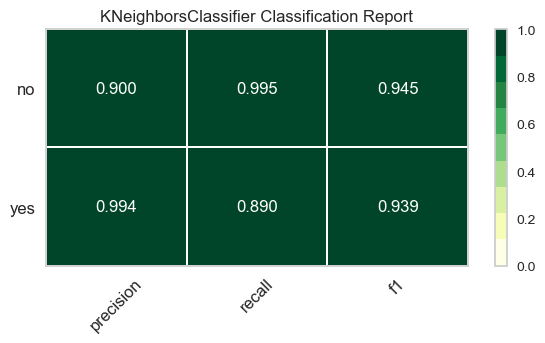

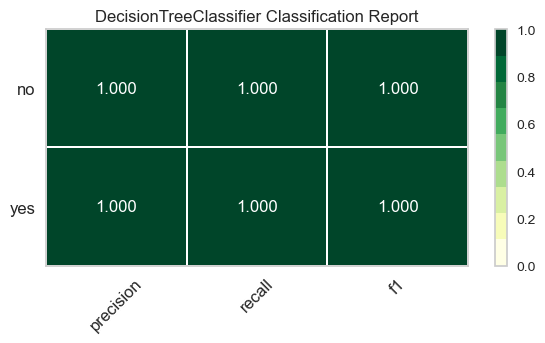

In [161]:
def visualize_model(X, y, estimator, **kwargs):

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['yes', 'no'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

for model in models:
    visualize_model(X_train, y_train, model)

In [162]:
def model_compare_matrix(X, y, model):
    model.fit(X, y)
    expected  = y
    predicted = model.predict(X)
    
    return accuracy_score(expected, predicted)

In [163]:
%%time
logreg_model = LogisticRegression()
logreg_train_accuracy = model_compare_matrix(X_train, y_train, logreg_model)

CPU times: user 946 ms, sys: 69.8 ms, total: 1.02 s
Wall time: 430 ms


In [164]:
logreg_test_accuracy = model_compare_matrix(X_test, y_test, logreg_model)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      9133
           1       0.86      0.87      0.86      9107

    accuracy                           0.86     18240
   macro avg       0.86      0.86      0.86     18240
weighted avg       0.86      0.86      0.86     18240

---------------------------------------------------------------------------------------


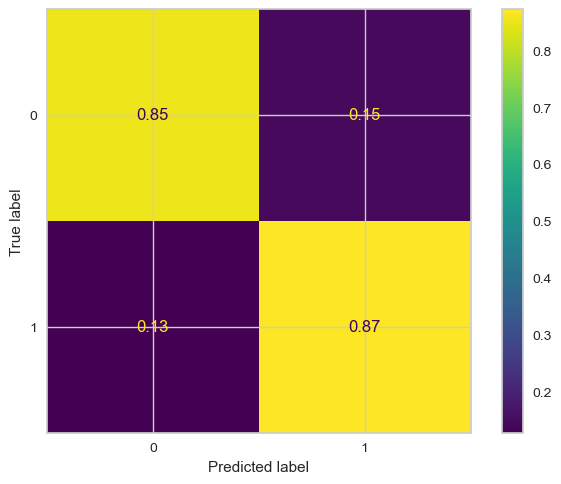

In [198]:
y_pred_logreg = logreg_model.predict(X_test)
print(classification_report(y_test, y_pred_logreg))
print('---------------------------------------------------------------------------------------')
plot_confusion_matrix(estimator=logreg_model, X=X_test, y_true=y_test, normalize='true')

In [165]:
%%time
svc_model = SVC(gamma='auto')
svc_train_accuracy = model_compare_matrix(X_train, y_train, svc_model)

CPU times: user 17min 12s, sys: 3.87 s, total: 17min 16s
Wall time: 17min 30s


In [166]:
svc_test_accuracy = model_compare_matrix(X_test, y_test, svc_model)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9133
           1       1.00      1.00      1.00      9107

    accuracy                           1.00     18240
   macro avg       1.00      1.00      1.00     18240
weighted avg       1.00      1.00      1.00     18240

---------------------------------------------------------------------------------------


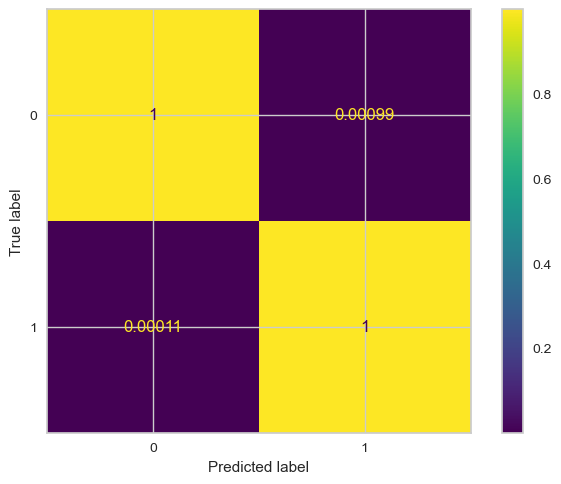

In [199]:
y_pred_svc = svc_model.predict(X_test)
print(classification_report(y_test, y_pred_svc))
print('---------------------------------------------------------------------------------------')
plot_confusion_matrix(estimator=svc_model, X=X_test, y_true=y_test, normalize='true')

In [167]:
%%time
knn_model = KNeighborsClassifier()
knn_train_accuracy = model_compare_matrix(X_train, y_train, knn_model)

CPU times: user 1min 2s, sys: 19.3 s, total: 1min 21s
Wall time: 57.6 s


In [168]:
knn_test_accuracy = model_compare_matrix(X_test, y_test, knn_model)

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9133
           1       0.88      0.98      0.93      9107

    accuracy                           0.92     18240
   macro avg       0.93      0.92      0.92     18240
weighted avg       0.93      0.92      0.92     18240

---------------------------------------------------------------------------------------


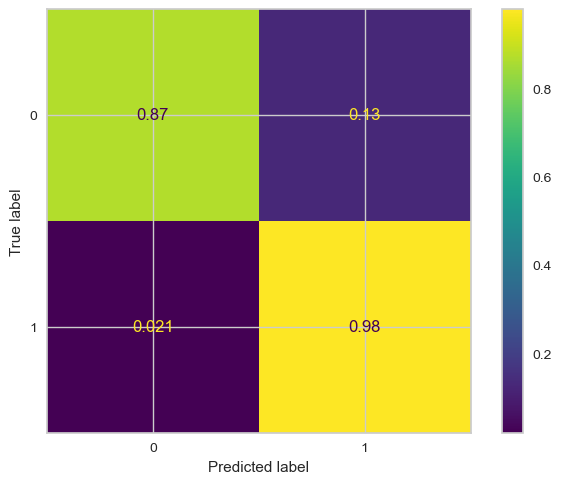

In [200]:
y_pred_knn = knn_model.predict(X_test)
print(classification_report(y_test, y_pred_knn))
print('---------------------------------------------------------------------------------------')
plot_confusion_matrix(estimator=knn_model, X=X_test, y_true=y_test, normalize='true')

In [169]:
%%time
dtc_model = DecisionTreeClassifier()
dtc_train_accuracy = model_compare_matrix(X_train, y_train, dtc_model)

CPU times: user 352 ms, sys: 3.87 ms, total: 356 ms
Wall time: 355 ms


In [170]:
dtc_test_accuracy = model_compare_matrix(X_test, y_test, dtc_model)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9133
           1       1.00      1.00      1.00      9107

    accuracy                           1.00     18240
   macro avg       1.00      1.00      1.00     18240
weighted avg       1.00      1.00      1.00     18240

---------------------------------------------------------------------------------------


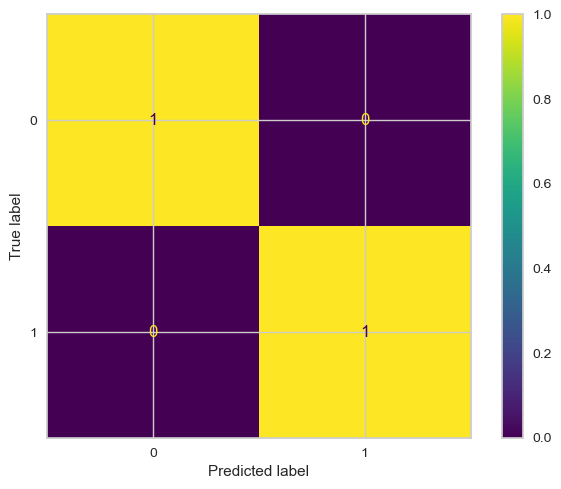

In [201]:
y_pred_dtc = dtc_model.predict(X_test)
print(classification_report(y_test, y_pred_dtc))
print('---------------------------------------------------------------------------------------')
plot_confusion_matrix(estimator=dtc_model, X=X_test, y_true=y_test, normalize='true')

In [173]:
df_results = {
    'Model': ['LogisticRegression', 'SVC', 'KNN', 'DecisionTree'],
    'Train Time': ['1.02s','17min 16s','1m 21s','356 ms'],
    'Train Accuracy': [logreg_train_accuracy,svc_train_accuracy,knn_train_accuracy,dtc_train_accuracy],
    'Test Accuracy': [logreg_test_accuracy,svc_test_accuracy,knn_test_accuracy,dtc_test_accuracy]
}

findings = pd.DataFrame(df_results)
findings

,Model,Train Time,Train Accuracy,Test Accuracy
0,LogisticRegression,1.02s,0.863944,0.862884
1,SVC,17min 16s,0.998684,0.999452
2,KNN,1m 21s,0.942325,0.924123
3,DecisionTree,356 ms,1.000000,1.000000


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### LogisticRegression GridSearchCV

In [174]:
%%time
params = {
    'lr__penalty' : ['l1','l2'], 
    'lr__C'       : np.logspace(-3,3,7),
    'lr__solver'  : ['newton-cg', 'lbfgs', 'liblinear']
}

logreg_pipe = Pipeline([('scale', StandardScaler()),
                     ('lr', LogisticRegression(random_state=42, max_iter = 1000))])
logreg_grid = GridSearchCV(logreg_pipe,            
                   param_grid = params,       
                   scoring='recall').fit(X_train, y_train)

best_logreg_params = logreg_grid.best_params_
best_train_score = logreg_grid.score(X_train, y_train)
best_test_score = logreg_grid.score(X_test, y_test)

print(f'Best parameters for logreg:", {best_logreg_params}')
print(f'The training recall score is: {best_train_score}')
print(f'The test recall score is: {best_test_score}')

Best parameters for logreg:", {'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg'}
The training recall score is: 0.8882475431995032
The test recall score is: 0.8894257164818271
CPU times: user 1min 35s, sys: 3.79 s, total: 1min 38s
Wall time: 34.8 s


In [175]:
logreg = {
    'Model': ['LogisticRegression'],
    'Train Time': ['1min 35s'],
    'Train Recall': [best_train_score],
    'Test Recall': [best_test_score]
}

df_logreg = pd.DataFrame(logreg)

##### SVC GridSearchCV

In [183]:
%%time
params = {
    'model__kernel': ['rbf', 'poly', 'linear', 'sigmoid']
}

svc_pipe = Pipeline([
    ('std', StandardScaler()),
    ('model', SVC()),
])

svc_grid = GridSearchCV(svc_pipe, param_grid=params, scoring='recall').fit(X_train, y_train)

svc_train_acc = svc_grid.score(X_train, y_train)
svc_test_acc = svc_grid.score(X_test, y_test)
best_params = svc_grid.best_params_

print(f'Best parameters for SVC: {best_params}')
print(f'The training recall score is: {svc_train_acc: .2f}')
print(f'The test recall score is: {svc_test_acc: .2f}')

Best parameters for SVC: {'model__kernel': 'rbf'}
The training recall score is:  0.95
The test recall score is:  0.95
CPU times: user 19min 42s, sys: 6.7 s, total: 19min 49s
Wall time: 19min 55s


In [184]:
svc = {
    'Model': ['SVC'],
    'Train Time': ['21 min'],
    'Train Recall': [svc_train_acc],
    'Test Recall': [svc_test_acc]
}

df_svc = pd.DataFrame(svc)

##### KNN GridSearchCV

In [177]:
%%time
params = {
    'knn__n_neighbors': list(range(1, 20, 2))
}

knn_pipe = Pipeline([('scale', StandardScaler()),
                     ('knn', KNeighborsClassifier())])
knn_grid = GridSearchCV(knn_pipe, param_grid=params, scoring='recall').fit(X_train, y_train)

knn_train_acc = knn_grid.score(X_train, y_train)
knn_test_acc = knn_grid.score(X_test, y_test)
best_params = knn_grid.best_params_

print(f'Best parameters for KNN: {best_params}')
print(f'The training recall score is: {knn_train_acc: .2f}')
print(f'The test recall score is: {knn_test_acc: .2f}')

Best parameters for KNN: {'knn__n_neighbors': 3}
The training recall score is:  0.98
The test recall score is:  0.95
CPU times: user 9min 14s, sys: 3min 1s, total: 12min 16s
Wall time: 8min 12s


In [178]:
knn = {
    'Model': ['KNN'],
    'Train Time': ['12min 37s'],
    'Train Recall': [knn_train_acc],
    'Test Recall': [knn_test_acc]
}

df_knn = pd.DataFrame(knn)

##### DecisionTreeClassifier GridSearchCV

In [179]:
%%time
params = {
    'min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
    'max_depth': [2, 5, 10],
    'min_samples_split': [0.1, 0.2, 0.05]
}

grid = ''
grid_train_acc = ''
grid_test_acc = ''
best_params = ''

grid = GridSearchCV(DecisionTreeClassifier(random_state = 42), 
                    param_grid=params, 
                    scoring='recall').fit(X_train, y_train)

grid_train_acc = grid.score(X_train, y_train)
grid_test_acc = grid.score(X_test, y_test)
best_params = grid.best_params_

print(f'Best parameters for tree: {best_params}')
print(f'The training recall score is: {grid_train_acc: .2f}')
print(f'The test recall score is: {grid_test_acc: .2f}')

Best parameters for tree: {'max_depth': 2, 'min_impurity_decrease': 0.03, 'min_samples_split': 0.1}
The training recall score is:  0.96
The test recall score is:  0.95
CPU times: user 11.9 s, sys: 394 ms, total: 12.3 s
Wall time: 12.4 s


In [180]:
dtc = {
    'Model': ['DecisionTreeClassifier'],
    'Train Time': ['12.7 s'],
    'Train Recall': [grid_train_acc],
    'Test Recall': [grid_test_acc]
}

df_dtc = pd.DataFrame(dtc)

In [185]:
df_tuned_findings = pd.concat([df_logreg,df_svc,df_knn,df_dtc])
df_tuned_findings.reset_index(drop=True)

,Model,Train Time,Train Recall,Test Recall
0,LogisticRegression,1min 35s,0.888248,0.889426
1,SVC,21 min,0.954006,0.945317
2,KNN,12min 37s,0.977715,0.948062
3,DecisionTreeClassifier,12.7 s,0.956928,0.953991


#### Performance Metrics

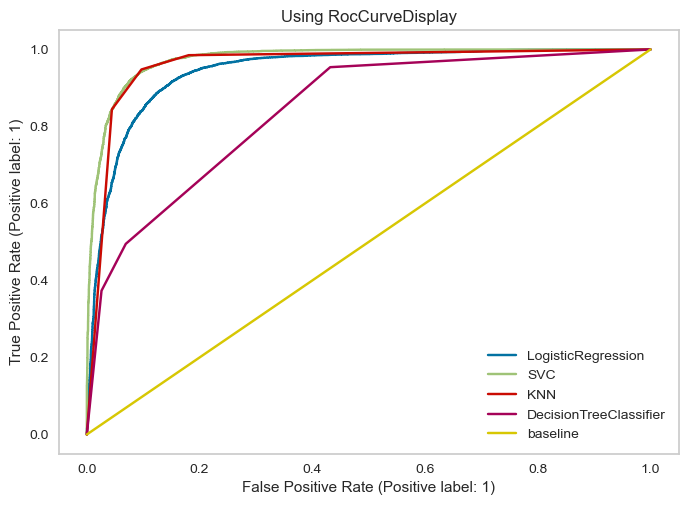

In [192]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(logreg_grid, X_test, y_test, pos_label = 1, ax = ax, label = 'LogisticRegression')
RocCurveDisplay.from_estimator(svc_grid, X_test, y_test, pos_label = 1, ax = ax, label = 'SVC')
RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, pos_label = 1, ax = ax, label = 'KNN')
RocCurveDisplay.from_estimator(grid, X_test, y_test, pos_label = 1, ax = ax, label = 'DecisionTreeClassifier')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend();

In [208]:
def acc_recall_graph(ac_lr, ac_svc, ac_knn, ac_dt, r_lr, r_svc, r_knn, r_dt):
    accuracy_data = [float(ac_lr)*100, float(ac_svc)*100, float(ac_knn)*100 ,float(ac_dt)*100]
    recall_data = [float(r_lr)*100, float(r_svc)*100, float(r_knn)*100, float(r_dt)*100]
    index = ['LR','SVC','KNN', 'DT']
    acc_pd = pd.DataFrame({'Accuracy Scores':accuracy_data,'Recall Scores':recall_data},index=index)
    acc_pd
    ax = acc_pd.plot(kind='bar', ylim=(0,100), xlabel='Classifiers', 
                     ylabel = 'Performance measure', legend=True, figsize=(15, 10))
    plt.figure(figsize=(21,9))
    ax.set_title('Accuracy & Recall Score of all classification model')

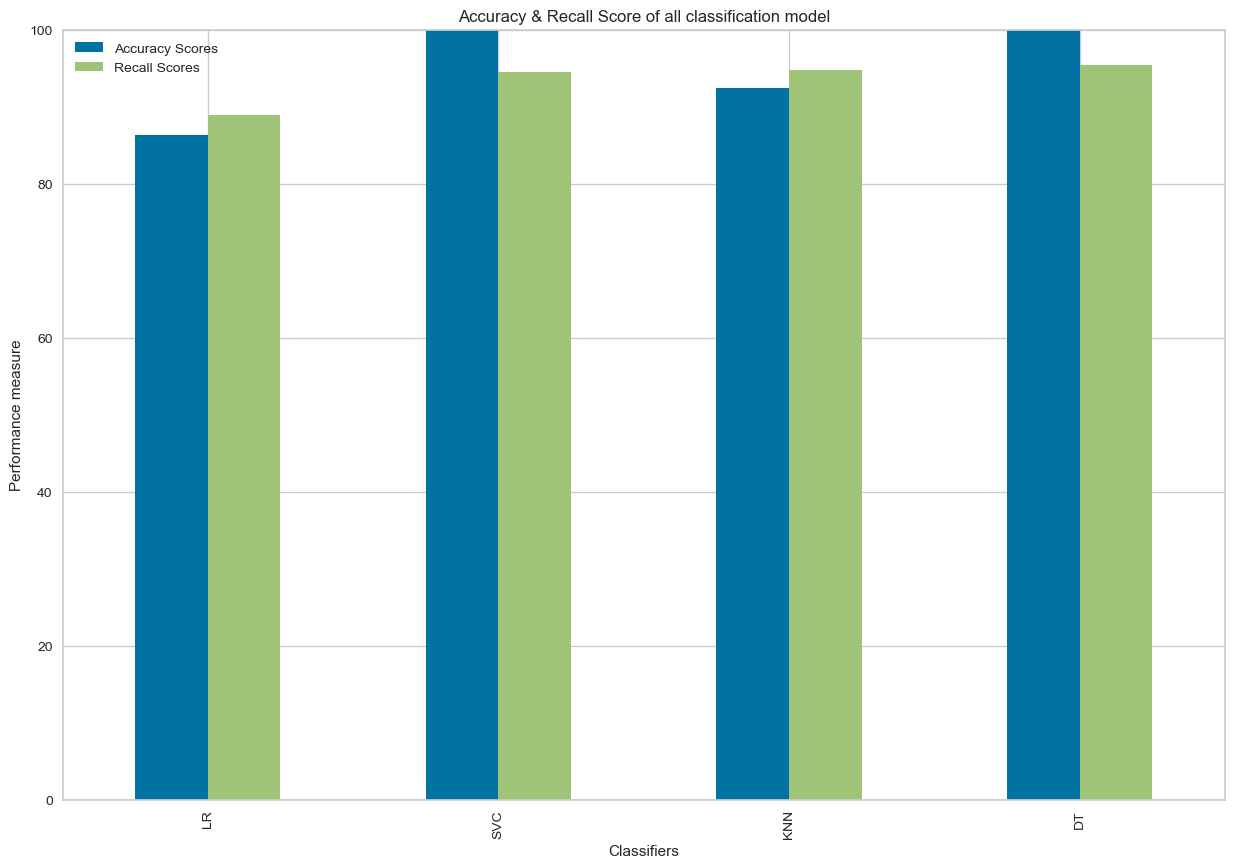

<Figure size 2100x900 with 0 Axes>

In [209]:
acc_recall_graph(0.862884, 0.999452, 0.924123, 1.000000, 0.889426, 0.945317, 0.948062, 0.953991)

#### Conclusion:

Based on the Accuracy & Recall scores ( recall being a more relevant metric ), its clear that the Decision Tree Classifier is performing much better than all the classifiers, with the highest Accuracy score & the recall score. Although SVC performance is good, it loses out in terms of the fit time. 

##### Questions

- Duration is highly corelated with response because a duration of 0s essentually means that the customer has not purchased the product.
- Using socio - economic indicators in the dataset will help improve model performance and will make predictions more accurate. For e.g. emp.var.rate, cons.price.idx, cons.conf.idx
- Target campaigns based on marital status & age - for e.g. clients who are married & in-between the ages 30-35 are more responsive to term deposits
- Day of the week is not a good indicator for making a prediction & hence can be factored out in the dataset.